In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install imblearn

In [3]:
import imblearn as im

In [4]:
from imblearn.datasets import fetch_datasets

In [5]:
mammography = fetch_datasets()['mammography']

In [6]:
X = pd.DataFrame(mammography['data'])
Y = pd.DataFrame(mammography['target'])

In [7]:
X.shape

(11183, 6)

In [8]:
X.describe()

,0,1,2,3,4,5
count,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04,1.118300e+04
mean,1.096536e-10,1.297595e-09,5.698113e-10,-2.435706e-09,-1.120680e-09,1.459483e-09
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
25%,-7.844148e-01,-4.701953e-01,-5.916315e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
50%,-1.085769e-01,-3.949941e-01,-2.309790e-01,-8.595525e-01,-3.778657e-01,-9.457232e-01
75%,3.139489e-01,-7.649473e-02,2.198366e-01,8.202077e-01,-3.778657e-01,1.016613e+00
max,3.150844e+01,5.085849e+00,2.947777e+01,9.591164e+00,2.361712e+01,1.949027e+00


[Text(0, 0, '10923'), Text(0, 0, '260')]

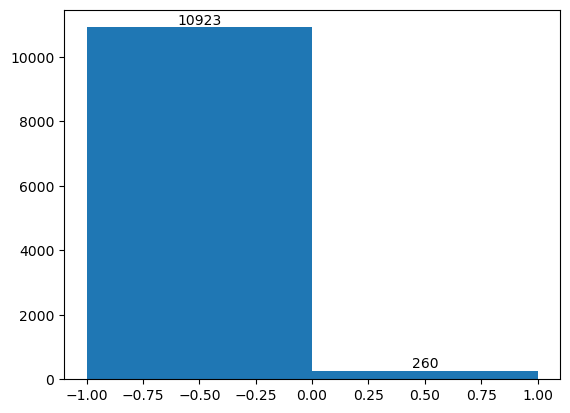

In [9]:
count, edges, bars = plt.hist(Y, bins=2)
plt.bar_label(bars)

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=123, stratify=Y)

In [12]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

In [13]:
def report(y, y_pred):
    print(classification_report_imbalanced(y, y_pred))
    print('-'*80)
    print(pd.DataFrame(confusion_matrix(y, y_pred), columns=['B', 'M'], index=['B', 'M']))

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
model = DecisionTreeClassifier(max_depth=6, min_samples_split=50, criterion='gini')

In [16]:
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=50)

In [17]:
report(y_train, model.predict(X_train))

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.63      0.99      0.79      0.65      8192
          1       0.85      0.63      1.00      0.72      0.79      0.61       195

avg / total       0.99      0.99      0.64      0.99      0.79      0.65      8387

--------------------------------------------------------------------------------
      B    M
B  8170   22
M    72  123


In [18]:
report(y_test, model.predict(X_test))

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      1.00      0.52      0.99      0.72      0.55      2731
          1       0.72      0.52      1.00      0.61      0.72      0.50        65

avg / total       0.98      0.98      0.53      0.98      0.72      0.54      2796

--------------------------------------------------------------------------------
      B   M
B  2718  13
M    31  34


In [19]:
from collections import Counter
from sklearn.decomposition import PCA

In [20]:
def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    return X_resampled, y_resampled

In [21]:
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.5):
    pca = PCA(n_components=2)
    pca.fit(X)

    X_pca = pca.transform(X)
    X_res_pca = pca.transform(X_resampled)

    X_stacked = [X_pca, X_res_pca]
    Y_stacked = [Y, Y_resampled]

    fig = plt.figure(figsize=(20,5))

    for i in range(2):
        ax = plt.subplot(1,2,i+1)
        colors = ['b' if y == -1 else 'r' for y in Y_stacked[i]]
        aplha = [x_opacity if y == -1 else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:,0], X_stacked[i][:,1], c=colors, alpha=aplha)
        # plt.title('ABCD')
    plt.show()

In [22]:
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test):
    m = DecisionTreeClassifier(max_depth=7, min_samples_split=25, criterion='gini')
    m.fit(X_train, Y_train)
    report(Y_train, m.predict(X_train))
    report(Y_test, m.predict(X_test))
    return m

In [23]:
from imblearn.over_sampling import RandomOverSampler

In [24]:
ros = RandomOverSampler(random_state=0, sampling_strategy='minority')

In [25]:
X_res, Y_res = resample(ros, X_train, y_train)

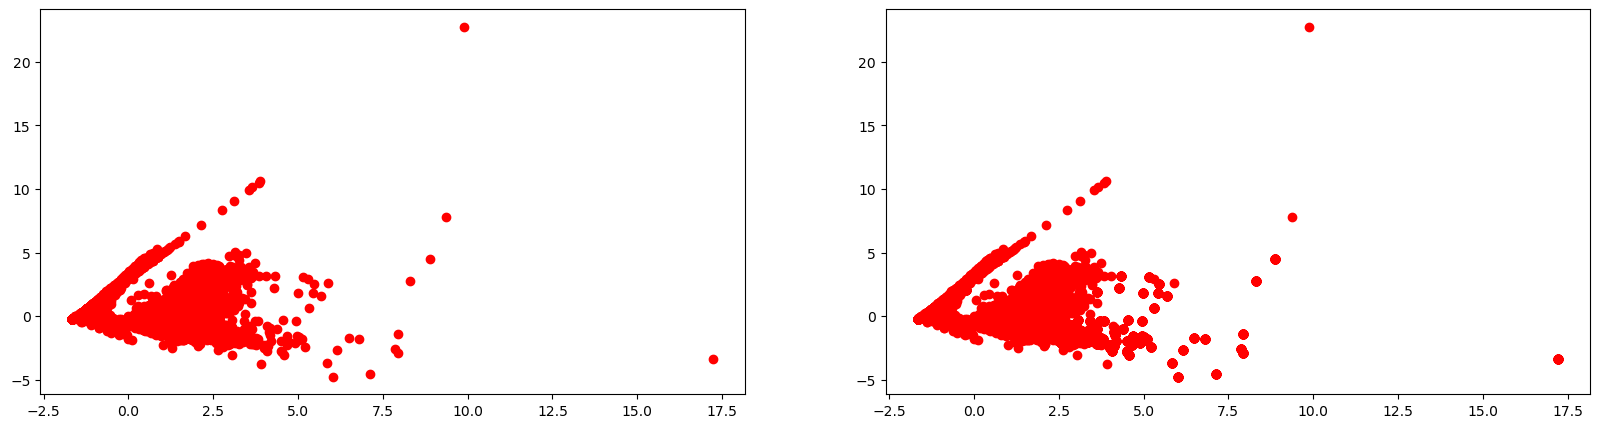

In [26]:
visualize(X_train, X_res, y_train, Y_res, 0)

In [27]:
model_ros = train_and_evaluate_model(X_res, Y_res, X_test, y_test)

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.93      0.97      0.93      0.95      0.95      0.90      8192
          1       0.97      0.93      0.97      0.95      0.95      0.89      8192

avg / total       0.95      0.95      0.95      0.95      0.95      0.90     16384

--------------------------------------------------------------------------------
      B     M
B  7926   266
M   593  7599
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.97      0.71      0.98      0.83      0.70      2731
          1       0.35      0.71      0.97      0.47      0.83      0.67        65

avg / total       0.98      0.96      0.71      0.97      0.83      0.70      2796

--------------------------------------------------------------------------------
      B   M
B  2645  86
M    19  46


In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
smote = SMOTE(k_neighbors=10, random_state=42)

In [30]:
X_res, Y_res = resample(smote, X_train, y_train)

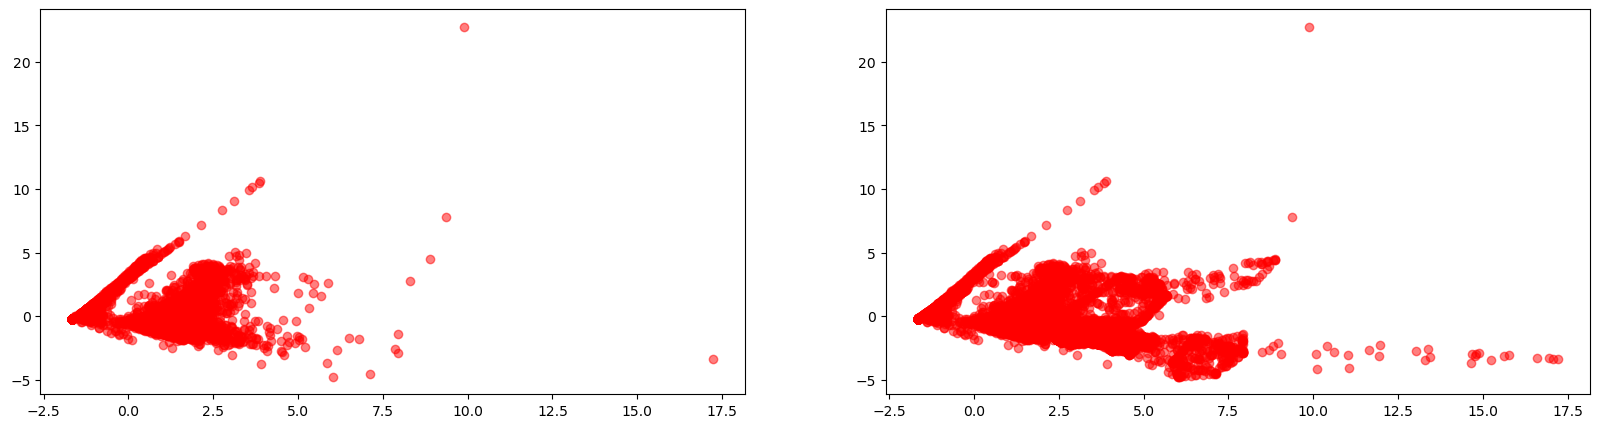

In [31]:
visualize(X_train, X_res, y_train, Y_res)

In [32]:
model_smote = train_and_evaluate_model(X_res, Y_res, X_train, y_train)

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.95      0.96      0.95      0.95      0.95      0.91      8192
          1       0.96      0.95      0.96      0.95      0.95      0.91      8192

avg / total       0.95      0.95      0.95      0.95      0.95      0.91     16384

--------------------------------------------------------------------------------
      B     M
B  7865   327
M   444  7748
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.96      0.91      0.98      0.94      0.88      8192
          1       0.35      0.91      0.96      0.51      0.94      0.87       195

avg / total       0.98      0.96      0.91      0.97      0.94      0.88      8387

--------------------------------------------------------------------------------
      B    M
B  7865  327
M    17  178


In [33]:
from imblearn.under_sampling import RandomUnderSampler

In [34]:
rus = RandomUnderSampler()

In [35]:
X_res, Y_res = resample(rus, X_train, y_train)

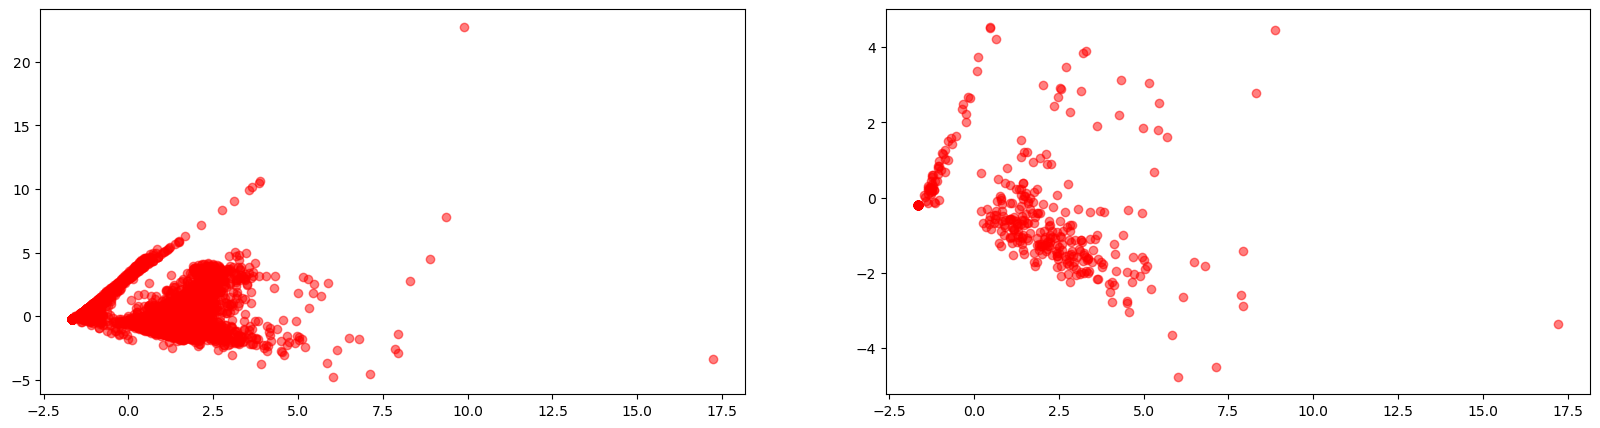

In [36]:
visualize(X_train, X_res, y_train, Y_res)

In [37]:
model_rus = train_and_evaluate_model(X_res, Y_res, X_train, y_train)

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.91      0.96      0.91      0.94      0.94      0.88       195
          1       0.96      0.91      0.96      0.93      0.94      0.87       195

avg / total       0.94      0.94      0.94      0.94      0.94      0.88       390

--------------------------------------------------------------------------------
     B    M
B  188    7
M   18  177
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.89      0.91      0.94      0.90      0.81      8192
          1       0.17      0.91      0.89      0.28      0.90      0.81       195

avg / total       0.98      0.89      0.91      0.93      0.90      0.81      8387

--------------------------------------------------------------------------------
      B    M
B  7312  880
M    18  177


In [38]:
from imblearn.under_sampling import NearMiss

In [39]:
nml = NearMiss(version=1, n_neighbors=20)

In [40]:
X_res, Y_res = resample(nml, X_train, y_train)

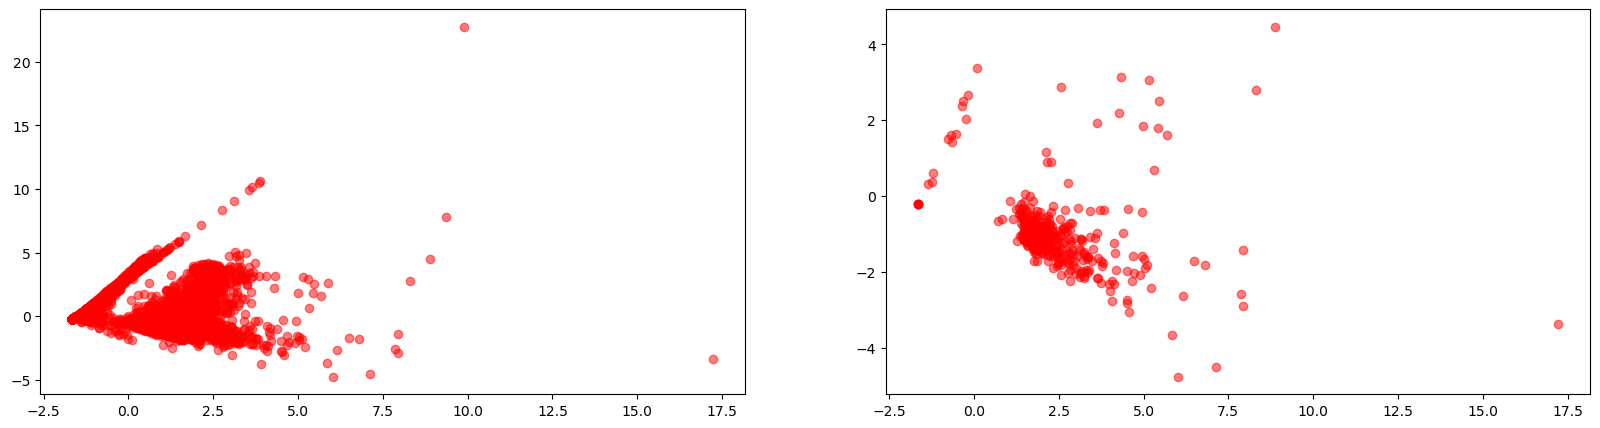

In [41]:
visualize(X_train, X_res, y_train, Y_res)

In [42]:
model_nml = train_and_evaluate_model(X_res, Y_res, X_train, y_train)

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.84      0.96      0.82      0.90      0.89      0.80       195
          1       0.96      0.82      0.96      0.88      0.89      0.78       195

avg / total       0.90      0.89      0.89      0.89      0.89      0.79       390

--------------------------------------------------------------------------------
     B    M
B  188    7
M   35  160
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.97      0.13      0.82      0.23      0.32      0.10      8192
          1       0.02      0.82      0.13      0.04      0.32      0.11       195

avg / total       0.95      0.14      0.80      0.22      0.32      0.10      8387

--------------------------------------------------------------------------------
      B     M
B  1051  7141
M    35   160


In [43]:
nm2 = NearMiss(version=2, n_neighbors=20)

In [44]:
X_res, Y_res = resample(nm2, X_train, y_train)

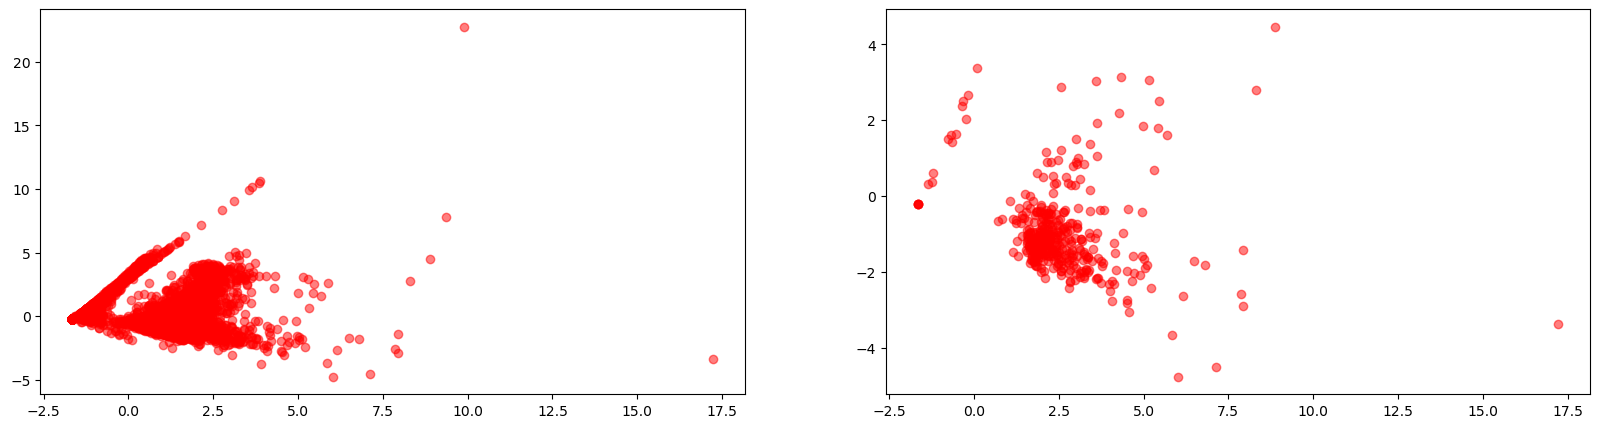

In [45]:
visualize(X_train, X_res, y_train, Y_res)

In [46]:
model_nm2 = train_and_evaluate_model(X_res, Y_res, X_train, y_train)

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.93      0.97      0.93      0.95      0.95      0.90       195
          1       0.97      0.93      0.97      0.95      0.95      0.90       195

avg / total       0.95      0.95      0.95      0.95      0.95      0.90       390

--------------------------------------------------------------------------------
     B    M
B  189    6
M   14  181
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.95      0.03      0.93      0.06      0.17      0.03      8192
          1       0.02      0.93      0.03      0.04      0.17      0.03       195

avg / total       0.93      0.05      0.91      0.06      0.17      0.03      8387

--------------------------------------------------------------------------------
     B     M
B  267  7925
M   14   181


In [47]:
nm3 = NearMiss(version=3, n_neighbors=20)

In [48]:
X_res, Y_res = resample(nm3, X_train, y_train)

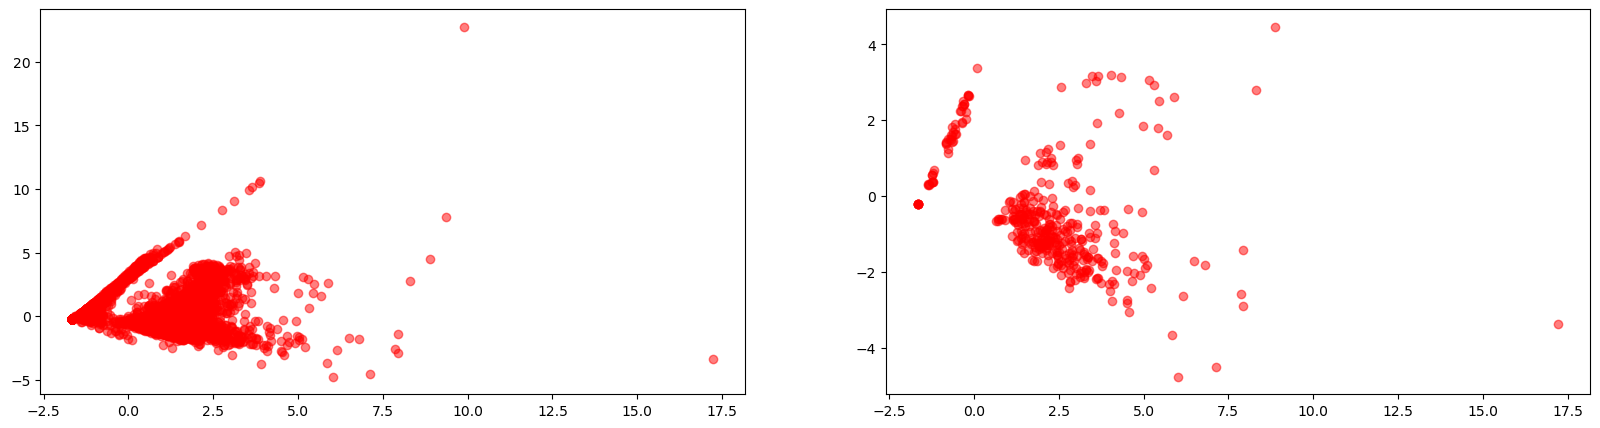

In [49]:
visualize(X_train, X_res, y_train, Y_res)

In [50]:
model_nm3 = train_and_evaluate_model(X_res, Y_res, X_train, y_train)

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.78      0.94      0.73      0.85      0.83      0.70       195
          1       0.92      0.73      0.94      0.81      0.83      0.67       195

avg / total       0.85      0.83      0.83      0.83      0.83      0.68       390

--------------------------------------------------------------------------------
     B    M
B  183   12
M   53  142
                   pre       rec       spe        f1       geo       iba       sup

         -1       0.99      0.59      0.73      0.74      0.66      0.43      8192
          1       0.04      0.73      0.59      0.08      0.66      0.44       195

avg / total       0.97      0.60      0.73      0.73      0.66      0.43      8387

--------------------------------------------------------------------------------
      B     M
B  4856  3336
M    53   142


In [51]:
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier

In [52]:
smoten = SMOTEENN(random_state=42, sampling_strategy='auto')

In [53]:
X_res, Y_res = resample(smoten, X_train, y_train)

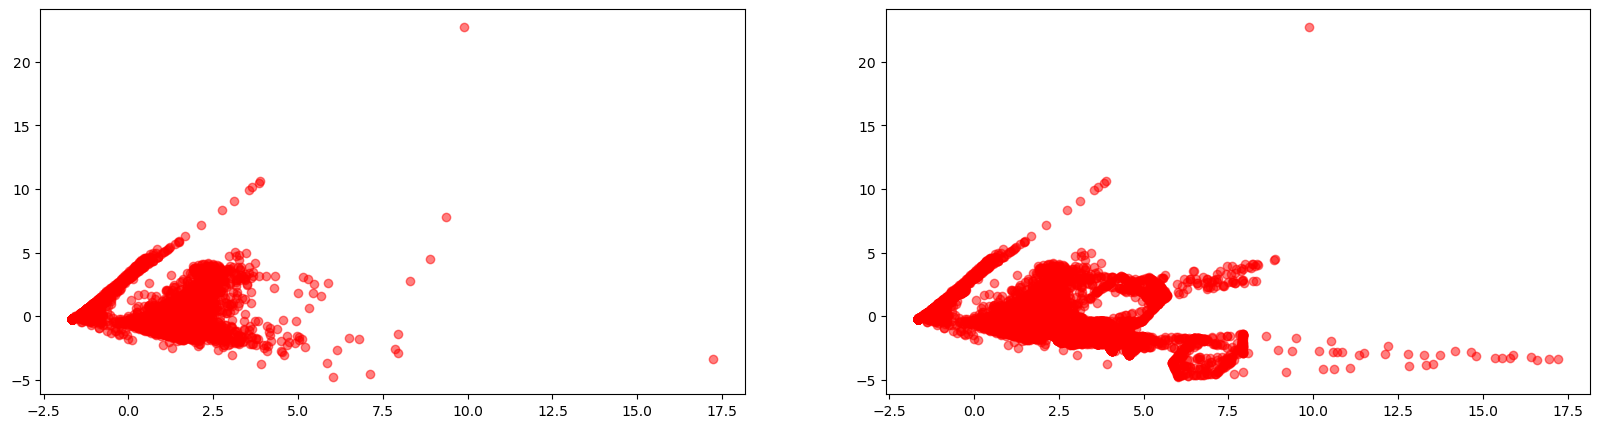

In [55]:
visualize(X_train, X_res, y_train, Y_res)

In [57]:
model_smoteenn = train_and_evaluate_model(X_res, Y_res, X_train, y_train)

                   pre       rec       spe        f1       geo       iba       sup

         -1       0.98      0.98      0.98      0.98      0.98      0.96      7760
          1       0.98      0.98      0.98      0.98      0.98      0.96      7882

avg / total       0.98      0.98      0.98      0.98      0.98      0.96     15642

--------------------------------------------------------------------------------
      B     M
B  7634   126
M   159  7723
                   pre       rec       spe        f1       geo       iba       sup

         -1       1.00      0.96      0.92      0.98      0.94      0.89      8192
          1       0.38      0.92      0.96      0.54      0.94      0.88       195

avg / total       0.98      0.96      0.92      0.97      0.94      0.89      8387

--------------------------------------------------------------------------------
      B    M
B  7903  289
M    16  179


In [58]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [59]:
model_es = BalancedRandomForestClassifier(max_depth=6, random_state=42, max_samples=20)

In [60]:
model_es.fit(X_train, y_train)

/home/natasa/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:546: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/home/natasa/anaconda3/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:558: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/home/natasa/anaconda3/lib/python3.11/site-packages/imblearn/utils/fixes.py:85: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


BalancedRandomForestClassifier(max_depth=6, max_samples=20, random_state=42)

In [61]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [62]:
models = [model, model_ros, model_smote, model_rus, model_nml, model_nm2, model_nm3, model_smoteenn]
model_names = ['DTC', 'ROS', 'SMOTE', 'RUS', 'NM1', 'NM2', 'NM3', 'SMOTEENN']

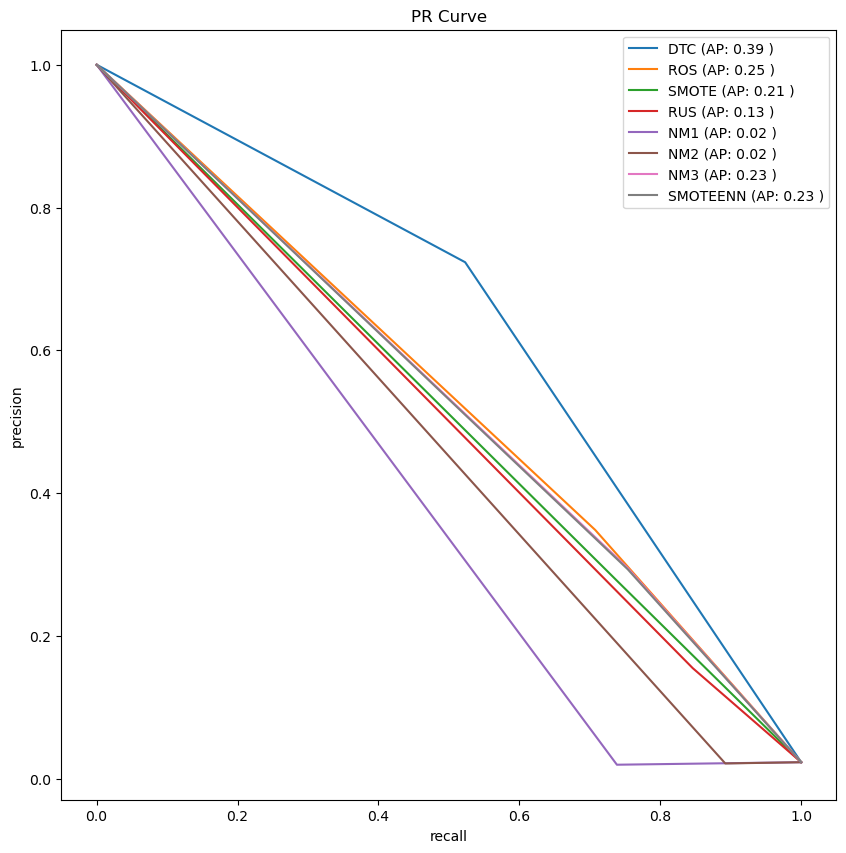

In [64]:
plt.figure(figsize=(10,10))
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    precision, recall, _ = precision_recall_curve(y_test, model.predict(X_test))
    ap = average_precision_score(y_test, model.predict(X_test))
    lab = model_name + ' (AP: ' + str(round(ap,2)) + ' )'
    plt.plot(recall, precision, label=lab)

plt.xlabel('recall')
plt.ylabel('precision')
plt.title('PR Curve')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import roc_auc_score, roc_curve

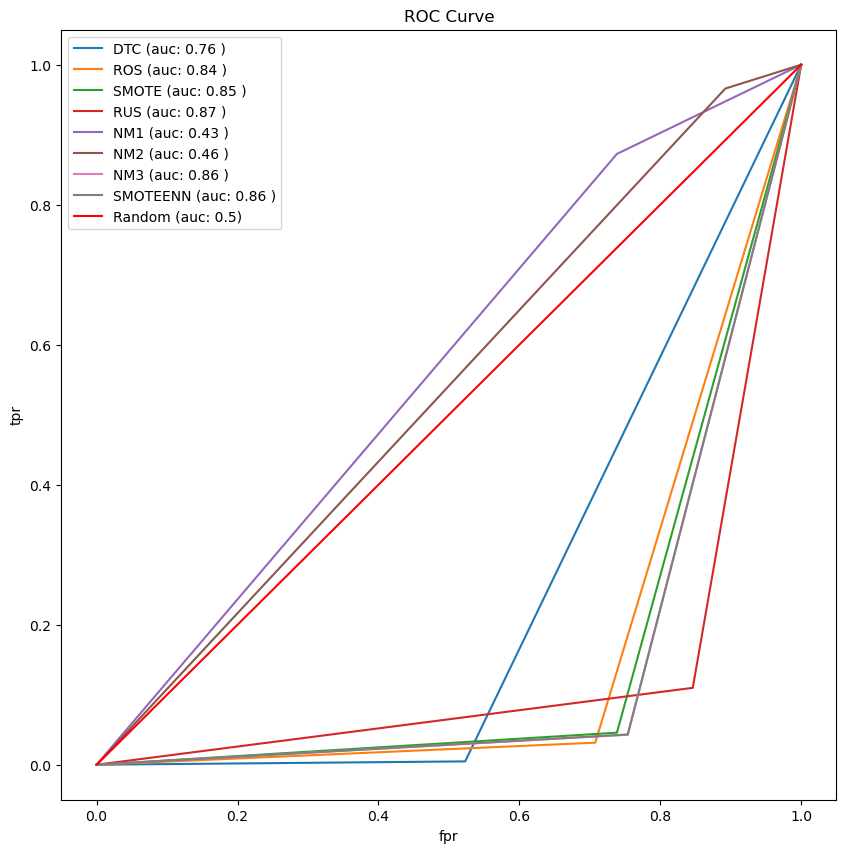

In [66]:
plt.figure(figsize=(10,10))

for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    tpr, fpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    lab = model_name + ' (auc: ' + str(round(auc,2)) + ' )'
    plt.plot(fpr, tpr, label=lab)

plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0,1], [0,1], label='Random (auc: 0.5)', color='red')
plt.title('ROC Curve')
plt.legend()
plt.show()